# Think Bayes: Chapter 9
Note: this exercise has been taken from the Think Bayes [book](http://www.greenteapress.com/thinkbayes/thinkbayes.pdf)

In [19]:
from __future__ import print_function, division

% matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import math
import numpy as np

import os, sys

sys.path.insert(1, os.path.join(sys.path[0], '..'))
import thinkbayes2
from thinkbayes2 import Pmf, Cdf, Suite, Joint
import thinkplot

** Question **

An “effect size” is a statistic intended to measure the difference between two groups (see http://en.wikipedia.org/wiki/Effect_size ). For example, we could use data from the BRFSS to estimate the difference in height between men and women. 

By sampling values from the posterior distributions of µ and σ, we could generate the posterior distribution of this difference. But it might be better to use a dimensionless measure of effect size, rather than a difference measured in cm. 

One option is to use divide through by the standard deviation (similar to what we did with the coefficient of variation). If the parameters for Group 1 are ($µ_1$, $σ_1$), and the parameters for Group 2 are ($µ_2$, $σ_2$), the dimensionless effect size is 
\begin{equation}
\frac{µ_1 − µ_2}{ (σ_1 + σ_2)/2}
\end{equation}
Write a function that takes joint distributions of mu and sigma for two groups and returns the posterior distribution of effect size.

**Solution **

The first step is to reproduce the distributions. For this, I'll take the code from the book, and remove what I don't need.

#### 1. Read the height data

In [5]:
import brfss

In [6]:
def ReadHeights(nrows=None):
    """Read the BRFSS dataset, extract the heights and pickle them.

    nrows: number of rows to read
    """
    resp = brfss.ReadBrfss(nrows=nrows).dropna(subset=['sex', 'htm3'])
    groups = resp.groupby('sex')

    d = {}
    for name, group in groups:
        d[name] = group.htm3.values

    return d

In [8]:
d = ReadHeights(nrows=None)
labels = {1:'male', 2:'female'}

We've read the data as a dictionary of arrays, with the data at `'1'` representing the male heights, and the data at `'2'` representing the female heights.

In [10]:
d

{1: array([ 170.,  185.,  183., ...,  191.,  178.,  178.]),
 2: array([ 157.,  163.,  165., ...,  165.,  170.,  157.])}

#### 2. Calculate the posterior distributions 

In [11]:
import variability

In [21]:
num_points=30
suites = {}
for key, xs in d.items():
    label = labels[key]
    xs = thinkbayes2.Jitter(xs, 1.3)

    mus, sigmas = variability.FindPriorRanges(xs, num_points, median_flag=True)
    suite = variability.Height(mus, sigmas, label)
    suites[label] = suite
    
    # run the update
    suite.Log()
    suite.LogUpdateSetMedianIPR(xs)
    suite.Exp()
    suite.Normalize()


classical estimators 178.360941611 7.41263320715
median, s 178.360941611 7.41263320715
classical estimators 163.338578245 7.14926824257
median, s 163.338578245 7.14926824257


I now have suites with posterior distributions for both males and females. Lets plot the marginals for $\mu$ and $\sigma$ for one gender.

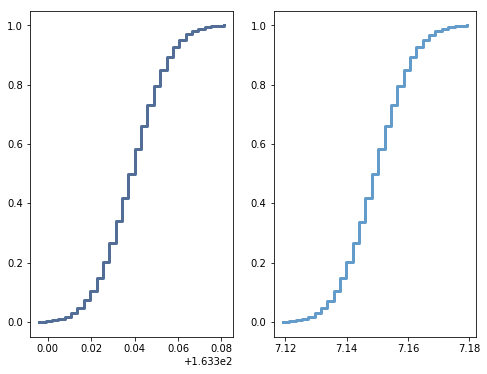

In [25]:
variability.PlotMarginals(suites['female'])

In order to find the effect size, I can just iterate through all $\mu$ $\sigma$ pairs, and calculate their effect size - and associated probability.

In [31]:
pmf = Pmf()
for fvals, fprob in suites['female'].Items():
    fmu, fsigma = fvals
    for mvals, mprob in suites['male'].Items():
        mmu, msigma = mvals
        
        diff = 2*(mmu - fmu)/(msigma + fsigma)
        pmf.Incr(diff, fprob*mprob)

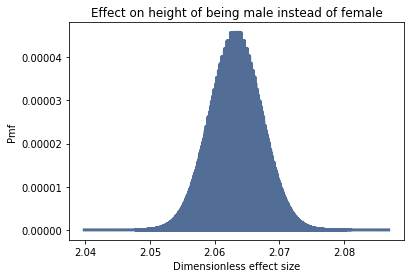

In [35]:
thinkplot.Plot(pmf)
thinkplot.Config(xlabel='Dimensionless effect size', ylabel='Pmf',
                 title='Effect on height of being male instead of female')